<a href="https://colab.research.google.com/github/vs-pereira/Tech-Challenge-5/blob/main/Datathon_Clusterizacao_Final_v6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análise de Perfis Ideais de Candidatos Contratados via Clusterização
Notebook completo revisado com todas as seções e melhorias.

## 1. Carregamento e Integração de Dados

In [1]:
import pandas as pd

# Montar Drive (Google Colab)
from google.colab import drive
drive.mount('/content/drive')

BASE = '/content/drive/MyDrive/Pós-Graduação - Data Analytics 2024 (FIAP)/Tech Challenge 5'
vagas = pd.read_json(f'{BASE}/vagas.json', orient='index')
prospects = pd.read_json(f'{BASE}/prospects.json', orient='index')
applicants = pd.read_json(f'{BASE}/applicants.json', orient='index')

# Explodir prospects
prospects = prospects.explode('prospects').reset_index(names=['job_id'])
prospects_full = pd.concat([
    prospects[['job_id']].reset_index(drop=True),
    pd.json_normalize(prospects['prospects'])
], axis=1)

# Criar is_hired
status_col = [c for c in prospects_full.columns if 'status' in c.lower() or 'situacao' in c.lower()][0]
prospects_full['is_hired'] = prospects_full[status_col].astype(str).str.contains('contrat', case=False).astype(int)

# Identificar id_candidato e merge
df = prospects_full.merge(vagas, how='left', left_on='job_id', right_index=True)
id_col = 'id_candidato' if 'id_candidato' in df.columns else 'codigo'
df[id_col] = df[id_col].astype(str)
applicants.index = applicants.index.astype(str)
df = df.merge(applicants, how='left', left_on=id_col, right_index=True)

print(df.shape)

Mounted at /content/drive
(56702, 19)


## 2. Pré-processamento dos Dados

In [3]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import json

# 1) Selecionar features e rótulo
cols_drop = ['job_id', id_col, status_col, 'is_hired']
df_feat = df.drop(columns=[c for c in cols_drop if c in df.columns])

# 2) Preencher ausentes numéricos e categóricos
for c in df_feat.select_dtypes(include='number'):
    df_feat[c] = df_feat[c].fillna(df_feat[c].median())
for c in df_feat.select_dtypes(include=['object', 'category']):
    df_feat[c] = df_feat[c].fillna('Desconhecido')

# 3) Converter quaisquer dicts em strings JSON para o OneHotEncoder
dict_cols = [
    c for c in df_feat.select_dtypes(include=['object', 'category']).columns
    if df_feat[c].apply(lambda x: isinstance(x, dict)).any()
]
for col in dict_cols:
    df_feat[col] = df_feat[col].apply(
        lambda x: json.dumps(x, ensure_ascii=False) if isinstance(x, dict)
                  else (str(x) if pd.notna(x) else 'Desconhecido')
    )
    # garantir que não há nulos depois da conversão
    df_feat[col] = df_feat[col].fillna('Desconhecido')

# 4) Preparar texto unificado
text_cols = [c for c in ['curriculo','comentario','competencias_tecnicas'] if c in df_feat]
df_feat[text_cols] = df_feat[text_cols].fillna('')
df_feat['texto_unificado'] = df_feat[text_cols].agg(' '.join, axis=1)

# 5) Definir colunas numéricas e categóricas
num_cols = df_feat.select_dtypes(include='number').columns.tolist()
cat_cols = [c for c in df_feat.select_dtypes(include=['object', 'category']).columns
            if c != 'texto_unificado']

# 6) Montar o pipeline de texto e o ColumnTransformer
text_pipe = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=20000, min_df=3)),
    ('svd', TruncatedSVD(n_components=100, random_state=42))
])

preproc = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols),
    ('txt', text_pipe, 'texto_unificado')
])

# 7) Aplicar transformação final
X = preproc.fit_transform(df_feat)
print('Shape X:', X.shape)

Shape X: (56702, 152097)


## 3. Redução de Dimensionalidade (UMAP)

In [4]:
import umap
reducer = umap.UMAP(n_neighbors=30, min_dist=0.0, metric='cosine', random_state=42)
X_2d = reducer.fit_transform(X)
print('Dimensão pós-UMAP:', X_2d.shape)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Dimensão pós-UMAP: (56702, 2)


## 4. Clusterização e Métricas

In [6]:
!pip install hdbscan
import hdbscan
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score

# HDBSCAN
clusterer = hdbscan.HDBSCAN(min_cluster_size=20, metric='euclidean')
labels_hdb = clusterer.fit_predict(X_2d)
n_hdb = len(set(labels_hdb)) - (1 if -1 in labels_hdb else 0)
print(f'HDBSCAN: {n_hdb} clusters (excluindo ruído)')
mask = labels_hdb != -1
print('Silhouette HDBSCAN:', silhouette_score(X_2d[mask], labels_hdb[mask]) if n_hdb>1 else 'N/A')

# K-Means
for k in range(2, 11):
    km = KMeans(n_clusters=k, random_state=42)
    lab = km.fit_predict(X_2d)
    sil = silhouette_score(X_2d, lab)
    db = davies_bouldin_score(X_2d, lab)
    print(f'K={k}: Silhouette={sil:.3f}, Davies-Bouldin={db:.3f}')

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


HDBSCAN: 333 clusters (excluindo ruído)
Silhouette HDBSCAN: 0.60160506
K=2: Silhouette=0.658, Davies-Bouldin=0.289
K=3: Silhouette=0.683, Davies-Bouldin=0.305
K=4: Silhouette=0.515, Davies-Bouldin=0.565
K=5: Silhouette=0.568, Davies-Bouldin=0.529
K=6: Silhouette=0.567, Davies-Bouldin=0.519
K=7: Silhouette=0.583, Davies-Bouldin=0.495
K=8: Silhouette=0.603, Davies-Bouldin=0.558
K=9: Silhouette=0.614, Davies-Bouldin=0.464
K=10: Silhouette=0.543, Davies-Bouldin=0.594


In [7]:
import hdbscan
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score

# HDBSCAN
clusterer = hdbscan.HDBSCAN(min_cluster_size=20)
labels_hdb = clusterer.fit_predict(X_2d)
df['cluster'] = labels_hdb

# K-Means K=3
km3 = KMeans(n_clusters=3, random_state=42)
df['cluster_k3'] = km3.fit_predict(X_2d)

print('HDBSCAN clusters:', len(set(labels_hdb)) - (1 if -1 in labels_hdb else 0))
print('Silhouette K=3:', silhouette_score(X_2d, df['cluster_k3']))
print('DB K=3:', davies_bouldin_score(X_2d, df['cluster_k3']))

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


HDBSCAN clusters: 333
Silhouette K=3: 0.6827471
DB K=3: 0.3051552857143532


## 5. Resumo de Contratação por Cluster

In [8]:
summary = (
    df[df['cluster']!=-1]
      .groupby('cluster')
      .agg(total=('cluster','size'),
           hired=('is_hired','sum'),
           pct_hired=('is_hired','mean'))
      .reset_index()
)
summary['pct_hired'] = (summary['pct_hired']*100).round(1)
print(summary.sort_values('pct_hired', ascending=False).head(10))

     cluster  total  hired  pct_hired
120      120     45     44       97.8
40        40     97     92       94.8
117      117     32     30       93.8
10        10     31     29       93.5
33        33     34     24       70.6
22        22    126     70       55.6
21        21    130     67       51.5
170      170     52     25       48.1
50        50     71     32       45.1
11        11    190     83       43.7


In [28]:
# → Exportar o DataFrame final com todas as colunas de cluster e is_hired
df.to_csv('df_final.csv', index=False)

In [29]:
%%bash
zip -j df_final.zip df_final.csv

updating: df_final.csv (deflated 79%)


## 6. Visualização: Top 10 Clusters

<ipython-input-11-4f6dc50da868>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


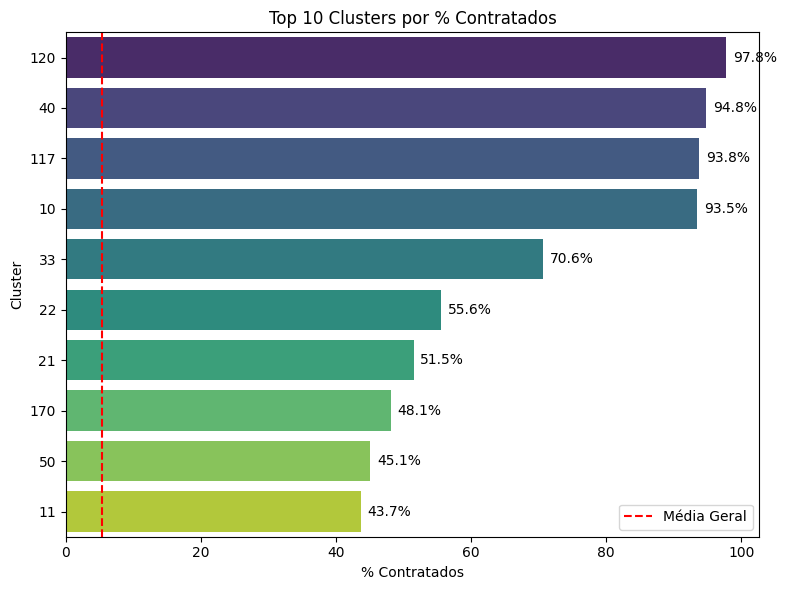

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Preparar dados
top10 = summary.sort_values('pct_hired', ascending=False).head(10)

# Plot
plt.figure(figsize=(8,6))
ax = sns.barplot(
    x='pct_hired',
    y='cluster',
    data=top10,
    palette='viridis',
    orient='h',
    order=top10['cluster']
)

# Linha da média geral
plt.axvline(df['is_hired'].mean()*100, color='red', linestyle='--', label='Média Geral')

# Inserir rótulos de dados (percentuais) ao lado de cada barra
for i, v in enumerate(top10['pct_hired']):
    ax.text(v + 1, i, f"{v}%", va='center')

# Ajustes finais
plt.title('Top 10 Clusters por % Contratados')
plt.xlabel('% Contratados')
plt.ylabel('Cluster')
plt.legend()
plt.tight_layout()
plt.show()

## 7. Flatten seletivo de atributos de candidatos

In [14]:
# Flatten corretivo
import pandas as pd

nested_cols = ['formacao_e_idiomas', 'informacoes_profissionais', 'infos_basicas']
for col in nested_cols:
    if col in df.columns:
        # substituir nulos por dict vazio
        df[col] = df[col].apply(lambda x: {} if pd.isna(x) else x)
        # normalizar lista de dicts
        flat = pd.json_normalize(df[col].tolist())
        # prefixar cada coluna para não colidir com df original
        flat.columns = [f"{col}_{c.split('.')[-1]}" for c in flat.columns]
        flat.index = df.index
        # remover a coluna aninhada e anexar as colunas prefixadas
        df = pd.concat([df.drop(columns=[col]), flat], axis=1)

# confira as novas colunas prefixadas
print("Exemplos de colunas extraídas:", df.columns.tolist()[:10])

Exemplos de colunas extraídas: ['job_id', 'nome', 'codigo', 'situacao_candidado', 'data_candidatura', 'ultima_atualizacao', 'comentario', 'recrutador', 'is_hired', 'informacoes_basicas']


## 8. Verificação das colunas extraídas

In [15]:
cols_check = ['certificacoes','outras_certificacoes','qualificacoes','experiencias',
               'outro_idioma','nivel_profissional','area_atuacao','sabendo_de_nos_por','nivel_ingles']
for c in cols_check:
    print(f"{c}: {'presente' if c in df.columns else 'ausente'}")

certificacoes: presente
outras_certificacoes: presente
qualificacoes: presente
experiencias: presente
outro_idioma: presente
nivel_profissional: presente
area_atuacao: presente
sabendo_de_nos_por: ausente
nivel_ingles: presente


## 9. Detalhamento do Top Cluster (120)

In [20]:
# Cluster de maior especificidade
cl = 120
detail_cols = [c for c in cols_check if c in df.columns]

print(f"=== Detalhamento Cluster {cl} (n={len(df[df['cluster']==cl])}) ===")
for col in detail_cols:
    serie = df[df['cluster']==cl][col].dropna()
    if serie.apply(lambda x: isinstance(x, list)).any():
        serie = serie.explode()
    vc = serie.value_counts().head(10)
    print(f"• {col}:")
    print(vc.to_string() if not vc.empty else "   (nenhum valor registrado)")

=== Detalhamento Cluster 120 (n=45) ===
• certificacoes:
certificacoes
                                                                                                                                                                                                                                                                                    42
MS [70-431] Microsoft SQL Server 2005 – Implementation and Maintenance                                                                                                                                                                                                               1
Linux Administrator Level I - LPIC I, ITIL v3 - IT Infraestructure Library                                                                                                                                                                                                           1
MS [70-642] Windows Server 2008 Network Infrastructure, Configuring, Oracle Certified Profes

## 10. Conclusões Finais

1. **Priorização de certificações formais**  
   1.1. Foco em **bancos de dados**: SQL Server (MS 70-431), Oracle (DBA, Solaris)  
   1.2. Foco em **infraestrutura**: Linux (LPIC I), ITIL v3  

2. **Áreas de atuação-chave**  
   2.1. **Desenvolvimento/Programação** (14/45)  
   2.2. **Gestão de Projetos** (8/45) e **Qualidade/Testes** (4/45)  

3. **Nível de inglês**  
   3.1. Inglês **Básico** e **Intermediário** predominam  
   3.2. Inglês **Avançado/Fluente** não é critério obrigatório  

4. **Micro-certificações e treinamentos rápidos**  
   4.1. 100 % dos contratados têm “outras_certificacoes” (workshops, cursos internos, etc.)  

In [22]:
# 1) Salvar o DataFrame como CSV no Colab
df_feat.to_csv('df_final.csv', index=False)

# 2) (Opcional) Baixar direto para sua máquina
from google.colab import files
files.download('df_final.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [24]:
# no Colab, depois de ter df_final definido:
df_feat.to_parquet('df_final', index=False, compression='gzip')

# faça o download
from google.colab import files
files.download('df_final')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [27]:
!zip df_final.zip df_final.csv

  adding: df_final.csv (deflated 80%)
